In [1]:
import sys
sys.path.append('../onitama/')
from trainer import RegularDataTrainer
from dl_players_v3 import CNNPlayer_v3
import numpy as np
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping

2026-01-22 22:57:29.450954: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-22 22:57:29.462475: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 22:57:29.937782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 22:57:32.107740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computat

In [2]:
def action_to_one_hot(action, shape=(5, 5, 52)):
    """
    Convertit une action [col, ligne, action_id] en one-hot tensor
    
    Args:
        action: [col, ligne, action_id] ou liste d'actions (batch)
        shape: (height, width, n_actions)
        
    Returns:
        one_hot: (5, 5, 52) ou (batch, 5, 5, 52)
    """
    if isinstance(action, list) and len(action) == 3:
        # Une seule action
        col, ligne, action_id = action
        one_hot = np.zeros(shape, dtype=np.float32)
        one_hot[col, ligne, action_id] = 1.0
        return one_hot
    else:
        # Batch d'actions
        batch_size = len(action)
        one_hot_batch = np.zeros((batch_size, *shape), dtype=np.float32)
        
        for i, act in enumerate(action):
            col, ligne, action_id = act
            one_hot_batch[i, col, ligne, action_id] = 1.0
        
        return one_hot_batch

def flat_index_to_action(flat_index):
    """
    Convertit index flat [0, 1299] en [col, ligne, move_id]
    """
    col = flat_index // (5 * 52)
    ligne = (flat_index // 52) % 5
    move_id = flat_index % 52
    return col, ligne, move_id


def decode_flat_policy(flat_policy):
    """
    Décode un vecteur aplati (1300,) en [col, ligne, move_id]
    
    Args:
        flat_policy: array de shape (1300,) - one-hot ou probabilités
        
    Returns:
        action: [col, ligne, move_id]
    """
    # 1. Trouver l'index du maximum (ou du 1.0 si one-hot)
    best_index = np.argmax(flat_policy)
    
    # 2. Décoder l'index
    col = best_index // (5 * 52)
    ligne = (best_index // 52) % 5
    move_id = best_index % 52
    
    return [int(col), int(ligne), int(move_id)]

def old_one_hot_to_action(action, verbose=False):
    """
    Convertit un one-hot tensor en action [col, ligne, move_id]
    
    Args:
        action: (5, 5, 52) ou (batch, 5, 5, 52)
        verbose: afficher les détails
        
    Returns:
        (col, ligne, move_id) ou liste de (col, ligne, move_id)
    """
    action = np.array(action)
    
    # Déterminer si c'est un batch ou une action seule
    if action.ndim == 3:
        # Une seule action (5, 5, 52)
        flat_logits = action.reshape(-1)
        
        exp_logits = np.exp(flat_logits - np.max(flat_logits))
        probabilities = exp_logits / exp_logits.sum()
        
        best_flat = np.argmax(probabilities)
        best_col, best_ligne, best_move_id = flat_index_to_action(best_flat)
        
        if verbose:
            print(f"Probabilités : {probabilities.shape}, sum={probabilities.sum():.3f}")
            print(f"Meilleure action : [{best_col}, {best_ligne}, {best_move_id}]")
            print(f"Probabilité : {probabilities[best_flat]:.4f}")
        
        return (best_col, best_ligne, best_move_id)
    
    elif action.ndim == 4:
        # Batch d'actions (batch, 5, 5, 52)
        batch_size = action.shape[0]
        results = []
        
        for i in range(batch_size):
            flat_logits = action[i].reshape(-1)
            
            exp_logits = np.exp(flat_logits - np.max(flat_logits))
            probabilities = exp_logits / exp_logits.sum()
            
            best_flat = np.argmax(probabilities)
            best_col, best_ligne, best_move_id = flat_index_to_action(best_flat)
            
            if verbose:
                print(f"[{i}] Probabilités : {probabilities.shape}, sum={probabilities.sum():.3f}")
                print(f"[{i}] Meilleure action : [{best_col}, {best_ligne}, {best_move_id}]")
                print(f"[{i}] Probabilité : {probabilities[best_flat]:.4f}")
            
            results.append((best_col, best_ligne, best_move_id))
        
        return results
    
    else:
        raise ValueError(f"Action doit avoir 3 ou 4 dimensions, reçu {action.ndim}")

In [3]:
#Récupération des données

folder_data = "../data/"

states_files = [
    'training-data-heuristic-vs-laheuristic2-states.pkl',
    'training-data-heuristic-vs-laheuristic3-2-states.pkl',
    'training-data-heuristic-vs-laheuristic3-states.pkl',
    'training-data-laheuristic2-vs-laheuristic3-states.pkl',
    'training-data-random-vs-laheuristic3-states.pkl',
    'agressive2-vs-defensive2-states.pkl',
    'agressive2-vs-mobility2-states.pkl',
    'defensive2-vs-positional2-states.pkl',
    'noisy2-vs-mobility2-states.pkl',
    'noisy2-vs-positional2-states.pkl',
    'positional2-vs-mobility2-states.pkl',
    'regular2-vs-defensive2-states.pkl'
]

policy_files = [
    'training-data-heuristic-vs-laheuristic2-actions.pkl',
    'training-data-heuristic-vs-laheuristic3-2-actions.pkl',
    'training-data-heuristic-vs-laheuristic3-actions.pkl',
    'training-data-laheuristic2-vs-laheuristic3-actions.pkl',
    'training-data-random-vs-laheuristic3-actions.pkl',
    'agressive2-vs-defensive2-actions.pkl',
    'agressive2-vs-mobility2-actions.pkl',
    'defensive2-vs-positional2-actions.pkl',
    'noisy2-vs-mobility2-actions.pkl',
    'noisy2-vs-positional2-actions.pkl',
    'positional2-vs-mobility2-actions.pkl',
    'regular2-vs-defensive2-actions.pkl'
]

states = []
policies = []

for i in range(len(states_files)):
    filename_states = folder_data+states_files[i]
    filename_policies = folder_data+policy_files[i]
    states += RegularDataTrainer.getTrainedData(filepath=filename_states)
    policies += RegularDataTrainer.getTrainedData(filepath=filename_policies)
    print(f"File {filename_states} loaded !")
    print(f"File {filename_policies} loaded !")

print("\n\nTotal :")
print(f"{len(states)} states")
print(f"{len(policies)} policies")

states = np.array(states)
print(states.shape)

#On est en (10, 5, 5) le réseau attend du (5, 5, 10) il faut transposer
states = np.transpose(states, (0, 2, 3, 1))
print(states.shape) #Maintenant on est bien (en 5,5,10)

File ../data/training-data-heuristic-vs-laheuristic2-states.pkl loaded !
File ../data/training-data-heuristic-vs-laheuristic2-actions.pkl loaded !
File ../data/training-data-heuristic-vs-laheuristic3-2-states.pkl loaded !
File ../data/training-data-heuristic-vs-laheuristic3-2-actions.pkl loaded !
File ../data/training-data-heuristic-vs-laheuristic3-states.pkl loaded !
File ../data/training-data-heuristic-vs-laheuristic3-actions.pkl loaded !
File ../data/training-data-laheuristic2-vs-laheuristic3-states.pkl loaded !
File ../data/training-data-laheuristic2-vs-laheuristic3-actions.pkl loaded !
File ../data/training-data-random-vs-laheuristic3-states.pkl loaded !
File ../data/training-data-random-vs-laheuristic3-actions.pkl loaded !
File ../data/agressive2-vs-defensive2-states.pkl loaded !
File ../data/agressive2-vs-defensive2-actions.pkl loaded !
File ../data/agressive2-vs-mobility2-states.pkl loaded !
File ../data/agressive2-vs-mobility2-actions.pkl loaded !
File ../data/defensive2-vs-po

In [4]:
# === DATA AUGMENTATION : MIROIR HORIZONTAL ===

def build_move_mirror_mapping():
    """
    Construit la table de correspondance move_idx → move_idx_mirrored
    basée sur les cartes d'Onitama (dx → -dx)
    """
    # Définition des cartes avec (dx, dy, move_idx)
    cards_moves = [
        # Tiger
        [(0, -2, 0), (0, 1, 1)],
        # Crab
        [(-2, 0, 2), (0, -1, 3), (2, 0, 4)],
        # Monkey
        [(-1, -1, 5), (1, -1, 6), (-1, 1, 7), (1, 1, 8)],
        # Crane
        [(0, -1, 9), (-1, 1, 10), (1, 1, 11)],
        # Dragon
        [(-2, -1, 12), (2, -1, 13), (-1, 1, 14), (1, 1, 15)],
        # Elephant
        [(-1, 0, 16), (1, 0, 17), (-1, -1, 18), (1, -1, 19)],
        # Mantis
        [(-1, -1, 20), (1, -1, 21), (0, 1, 22)],
        # Boar
        [(-1, 0, 23), (0, -1, 24), (1, 0, 25)],
        # Frog
        [(-2, 0, 26), (-1, -1, 27), (1, 1, 28)],
        # Goose
        [(-1, 0, 29), (-1, -1, 30), (1, 0, 31), (1, 1, 32)],
        # Horse
        [(-1, 0, 33), (0, -1, 34), (0, 1, 35)],
        # Eel
        [(-1, -1, 36), (1, 0, 37), (-1, 1, 38)],
        # Rabbit
        [(-1, 1, 39), (2, 0, 40), (1, -1, 41)],
        # Rooster
        [(1, -1, 42), (-1, 0, 43), (1, 0, 44), (-1, 1, 45)],
        # Ox
        [(0, -1, 46), (1, 0, 47), (0, 1, 48)],
        # Cobra
        [(-1, 0, 49), (1, -1, 50), (1, 1, 51)],
    ]
    
    # Créer un dictionnaire (dx, dy) → move_idx pour chaque carte
    move_to_idx = {}  # (dx, dy) → move_idx
    idx_to_move = {}  # move_idx → (dx, dy)
    
    for card_moves in cards_moves:
        for dx, dy, move_idx in card_moves:
            move_to_idx[(dx, dy, move_idx)] = move_idx
            idx_to_move[move_idx] = (dx, dy)
    
    # Construire le mapping miroir
    mirror_mapping = {}
    
    for card_moves in cards_moves:
        # Pour chaque carte, trouver les paires de mouvements miroirs
        moves_dict = {(dx, dy): idx for dx, dy, idx in card_moves}
        
        for dx, dy, move_idx in card_moves:
            mirrored_dx = -dx
            if (mirrored_dx, dy) in moves_dict:
                mirror_mapping[move_idx] = moves_dict[(mirrored_dx, dy)]
            else:
                # Mouvement sur l'axe vertical (dx=0), reste identique
                mirror_mapping[move_idx] = move_idx
    
    return mirror_mapping

# Construire le mapping une fois
MOVE_MIRROR_MAPPING = build_move_mirror_mapping()

def augment_horizontal_flip(states, policies_flat):
    """
    Applique un miroir horizontal aux états et policies
    
    Args:
        states: (batch, 5, 5, 10) - états du jeu
        policies_flat: (batch, 1300) - policies aplaties
        
    Returns:
        states_aug: (2*batch, 5, 5, 10)
        policies_aug: (2*batch, 1300)
    """
    batch_size = states.shape[0]
    
    # 1. Flip des états : inverser l'axe des colonnes (axis=1)
    states_flipped = np.flip(states, axis=1).copy()
    
    # 2. Flip des policies
    policies_flipped = np.zeros_like(policies_flat)
    
    for i in range(batch_size):
        # Trouver l'action originale
        flat_idx = np.argmax(policies_flat[i])
        col = flat_idx // (5 * 52)
        ligne = (flat_idx // 52) % 5
        move_id = flat_idx % 52
        
        # Appliquer le miroir
        new_col = 4 - col  # Inverser la colonne (0↔4, 1↔3, 2↔2)
        new_move_id = MOVE_MIRROR_MAPPING[move_id]
        
        # Calculer le nouvel index flat
        new_flat_idx = new_col * (5 * 52) + ligne * 52 + new_move_id
        policies_flipped[i, new_flat_idx] = 1.0
    
    # 3. Concatener original + flipped
    states_aug = np.concatenate([states, states_flipped], axis=0)
    policies_aug = np.concatenate([policies_flat, policies_flipped], axis=0)
    
    return states_aug, policies_aug

# Test
print("Move mirror mapping (exemples):")
print(f"  Move 2 (-2,0) → Move {MOVE_MIRROR_MAPPING[2]} (devrait être 4: +2,0)")
print(f"  Move 5 (-1,-1) → Move {MOVE_MIRROR_MAPPING[5]} (devrait être 6: +1,-1)")
print(f"  Move 0 (0,-2) → Move {MOVE_MIRROR_MAPPING[0]} (devrait être 0: vertical)")


Move mirror mapping (exemples):
  Move 2 (-2,0) → Move 4 (devrait être 4: +2,0)
  Move 5 (-1,-1) → Move 6 (devrait être 6: +1,-1)
  Move 0 (0,-2) → Move 0 (devrait être 0: vertical)


In [5]:

#On applique one Hot Encoder sur les actions (policies)
policies = action_to_one_hot(policies)

#Aplatir pour correspondre à la sortie du modèle
policies = policies.reshape(-1, 5 * 5 * 52)  # (batch, 1300)

#On applique l'augmentation
states, policies = augment_horizontal_flip(states, policies)

#print(f"Après augmentation: {len(states)} états, {len(policies)} policies")
#print(policies.shape)



In [6]:
print(policies[0])

[0. 0. 0. ... 0. 0. 0.]


In [7]:
network = CNNPlayer_v3(dropout_rate=0.3)

2026-01-22 22:58:34.983688: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
# Compiler pour supervised (gèle value head)
network.compile_for_supervised_policy()

Gelé 7 layers de la tête de valeur
Modèle compilé pour entraînement supervisé (policy seulement, label_smoothing=0.1, weight_decay=0.0001)


In [9]:
network.summary()

Model: "OnitamaNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ state_input         │ (None, 5, 5, 10)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_input (Conv2D) │ (None, 5, 5, 64)  │      5,824 │ state_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_input            │ (None, 5, 5, 64)  │        256 │ conv_input[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_input          │ (None, 5, 5, 64)  │          0 │ bn_input[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_0_conv1   │ (None, 5, 5, 64)  │     36,928 │ relu_input[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_0_bn1     │ (None, 5, 5, 64)  │        256 │ res_block_0_conv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_0_relu1   │ (None, 5, 5, 64)  │          0 │ res_block_0_bn1[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_0_conv2   │ (None, 5, 5, 64)  │     36,928 │ res_block_0_relu… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_0_bn2     │ (None, 5, 5, 64)  │        256 │ res_block_0_conv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_0_add     │ (None, 5, 5, 64)  │          0 │ res_block_0_bn2[… │
│ (Add)               │                   │            │ relu_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_0_relu2   │ (None, 5, 5, 64)  │          0 │ res_block_0_add[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_1_conv1   │ (None, 5, 5, 64)  │     36,928 │ res_block_0_relu… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_1_bn1     │ (None, 5, 5, 64)  │        256 │ res_block_1_conv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_1_relu1   │ (None, 5, 5, 64)  │          0 │ res_block_1_bn1[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_1_conv2   │ (None, 5, 5, 64)  │     36,928 │ res_block_1_relu… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_1_bn2     │ (None, 5, 5, 64)  │        256 │ res_block_1_conv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block_1_add     │ (None, 5, 5, 64)  │          0 │ res_block_1_bn2[… │
│ (Add)               │                   │            │ res_block_0_relu

 Total params: 165,545 (646.66 KB)

 Trainable params: 158,036 (617.33 KB)

 Non-trainable params: 7,509 (29.33 KB)

In [10]:
x_train = np.array(states)
y_policy = policies
y_value = np.zeros((len(x_train), 1))

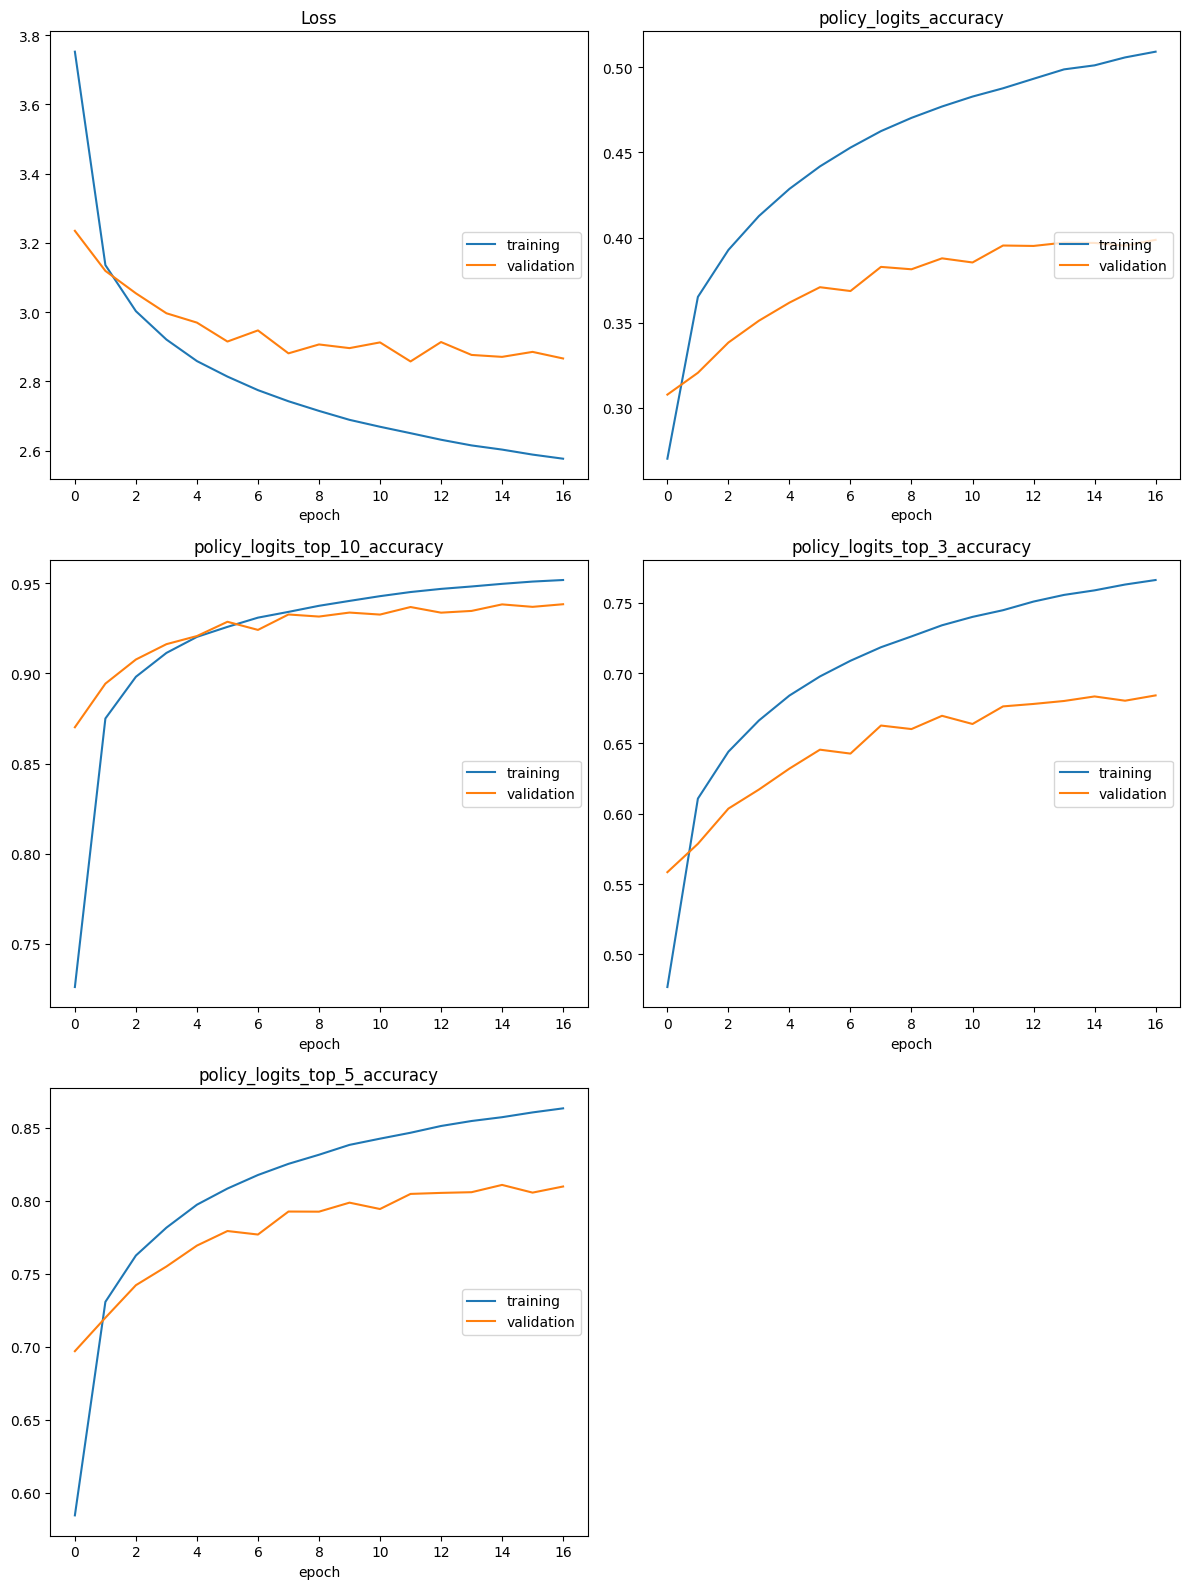

Loss
	training         	 (min:    2.577, max:    3.752, cur:    2.577)
	validation       	 (min:    2.858, max:    3.235, cur:    2.866)
policy_logits_accuracy
	training         	 (min:    0.270, max:    0.509, cur:    0.509)
	validation       	 (min:    0.308, max:    0.399, cur:    0.399)
policy_logits_top_10_accuracy
	training         	 (min:    0.726, max:    0.952, cur:    0.952)
	validation       	 (min:    0.870, max:    0.938, cur:    0.938)
policy_logits_top_3_accuracy
	training         	 (min:    0.477, max:    0.766, cur:    0.766)
	validation       	 (min:    0.558, max:    0.684, cur:    0.684)
policy_logits_top_5_accuracy
	training         	 (min:    0.584, max:    0.863, cur:    0.863)
	validation       	 (min:    0.697, max:    0.811, cur:    0.810)
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 216s 29ms/step - loss: 2.5771 - policy_logits_accuracy: 0.5092 - policy_logits_top_10_accuracy: 0.9519 - policy_logits_top_3_accuracy: 0.7663 - policy_logits_top_5_accuracy: 0.8631 - val_loss: 

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',      # Surveille la validation loss
    patience=5,              # Arrête après 5 epochs sans amélioration
    restore_best_weights=True # Restaure les poids du meilleur epoch
)

# Entraîner
history = network.fit(
    x_train,
    [y_policy, y_value],  # y_value sera ignoré
    batch_size=64,
    shuffle=True,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop, PlotLossesKeras()]
)

In [ ]:
#Sauvegarder les poids
network.save_weights("../saved-models/CNNPlayer-v3-augmented-weights.weights.h5")

#Sauvegarder le modèle
network.save("../saved-models/CNNPlayer-v3-augmented-model.keras")

In [ ]:
# === ÉVALUATION TOP-K ACCURACY SUR MODÈLE EXISTANT ===

def evaluate_top_k_accuracy(network, x_data, y_policy, k_values=[1, 3, 5, 10], batch_size=256):
    """
    Évalue les métriques top-k accuracy sur un modèle déjà entraîné.
    
    Args:
        network: Le modèle CNNPlayer
        x_data: États (N, 5, 5, 10)
        y_policy: Policies one-hot (N, 1300)
        k_values: Liste des k pour top-k accuracy
        batch_size: Taille des batchs pour la prédiction
    
    Returns:
        dict avec les accuracies pour chaque k
    """
    n_samples = len(x_data)
    
    # Récupérer les indices des vraies actions
    y_true_indices = np.argmax(y_policy, axis=1)  # (N,)
    
    # Prédire par batch pour éviter les problèmes de mémoire
    all_logits = []
    for i in range(0, n_samples, batch_size):
        batch_x = x_data[i:i+batch_size]
        policy_logits, _ = network.model(batch_x, training=False)
        all_logits.append(policy_logits.numpy())
    
    all_logits = np.concatenate(all_logits, axis=0)  # (N, 1300)
    
    # Calculer top-k accuracy pour chaque k
    results = {}
    for k in k_values:
        # Trouver les top-k indices pour chaque prédiction
        top_k_indices = np.argsort(all_logits, axis=1)[:, -k:]  # (N, k)
        
        # Vérifier si la vraie action est dans le top-k
        correct = np.array([y_true_indices[i] in top_k_indices[i] for i in range(n_samples)])
        accuracy = correct.mean()
        results[f'top_{k}'] = accuracy
    
    return results

# Évaluer sur les données (sans augmentation pour comparaison équitable)
print("Évaluation des métriques top-k sur le modèle actuel...")
print(f"Nombre d'échantillons: {len(x_train)}")
print()

results = evaluate_top_k_accuracy(network, x_train, y_policy)

print("=" * 40)
print("RÉSULTATS TOP-K ACCURACY")
print("=" * 40)
for metric, value in results.items():
    print(f"  {metric}: {value:.2%}")
print("=" * 40)

# Interprétation
print("\nInterprétation:")
if results['top_5'] >= 0.7:
    print("✓ Le modèle place généralement les bons coups dans le top 5")
elif results['top_5'] >= 0.5:
    print("~ Performance moyenne - le modèle a une certaine compréhension")
else:
    print("✗ Performance faible - problème de données ou d'architecture")

In [13]:

def predict_action(network, state, deterministic=True, valid_actions_mask=None):
    """
    Prédit une action à partir d'un état
    
    Args:
        network: Le réseau de neurones
        state: (5, 5, 10) - un état (sans batch dimension)
        deterministic: Si True, prend l'action avec le score max
                      Si False, échantillonne selon les probabilités
        valid_actions_mask: (5, 5, 52) optionnel - masque des actions valides
        
    Returns:
        action: [col, ligne, move_id]
        probability: probabilité de cette action
    """
    # 1. Ajouter la dimension batch si nécessaire
    if len(state.shape) == 3:
        state_batch = np.expand_dims(state, axis=0)  # (1, 5, 5, 10)
    else:
        state_batch = state
    
    # 2. Prédiction
    policy_logits, value = network.predict(state_batch, training=False)
    
    # 3. Retirer la dimension batch
    policy_logits = policy_logits.numpy()
    policy_logits = policy_logits[0]  # (5, 5, 52)
    value = value[0, 0]  # Scalar
    
    # 4. Masquer les actions invalides (optionnel mais IMPORTANT)
    if valid_actions_mask is not None:
        large_negative = -1e9
        masked_logits = np.where(
            valid_actions_mask,
            policy_logits,
            large_negative
        )
    else:
        masked_logits = policy_logits
    
    # 5. Aplatir en (1300,) pour faciliter le traitement
    flat_logits = masked_logits.reshape(-1)  # (5*5*52 = 1300,)
    
    # 6. Convertir en probabilités avec softmax
    flat_probs = softmax(flat_logits)
    
    # 7. Sélectionner l'action
    if deterministic:
        # Prendre l'action avec la probabilité max
        best_index = np.argmax(flat_probs)
    else:
        # Échantillonner selon les probabilités
        best_index = np.random.choice(len(flat_probs), p=flat_probs)
    
    # 8. Décoder l'index en [col, ligne, move_id]
    col = best_index // (5 * 52)
    ligne = (best_index // 52) % 5
    move_id = best_index % 52
    
    action = [int(col), int(ligne), int(move_id)]
    probability = flat_probs[best_index]
    
    return action, probability, value


def softmax(x):
    """Calcule le softmax de manière stable numériquement"""
    exp_x = np.exp(x - np.max(x))  # Soustraire le max pour stabilité
    return exp_x / exp_x.sum()

In [14]:
#Vérification des prédictions pour les premiers états

for i in range(10):
    # Prédire l'action (déterministe)
    state = x_train[i]
    action_reelle = y_policy[i]
    action, prob, value = predict_action(network, state, deterministic=True)

    print("---------------------")
    print(f"État: {state.shape}")
    print(f"Action prédite: {action}")
    print(f"  → Colonne: {action[0]}")
    print(f"  → Ligne: {action[1]}")
    print(f"  → Mouvement: {action[2]}")
    print(f"Probabilité: {prob:.4f}")

    print(decode_flat_policy(action_reelle))


---------------------
État: (5, 5, 10)
Action prédite: [0, 4, 42]
  → Colonne: 0
  → Ligne: 4
  → Mouvement: 42
Probabilité: 0.8175
[0, 4, 42]
---------------------
État: (5, 5, 10)
Action prédite: [4, 4, 30]
  → Colonne: 4
  → Ligne: 4
  → Mouvement: 30
Probabilité: 0.1441
[4, 4, 30]
---------------------
État: (5, 5, 10)
Action prédite: [1, 4, 46]
  → Colonne: 1
  → Ligne: 4
  → Mouvement: 46
Probabilité: 0.9222
[1, 4, 46]
---------------------
État: (5, 5, 10)
Action prédite: [0, 4, 50]
  → Colonne: 0
  → Ligne: 4
  → Mouvement: 50
Probabilité: 0.4772
[2, 4, 50]
---------------------
État: (5, 5, 10)
Action prédite: [0, 4, 19]
  → Colonne: 0
  → Ligne: 4
  → Mouvement: 19
Probabilité: 0.2041
[3, 3, 29]
---------------------
État: (5, 5, 10)
Action prédite: [0, 4, 19]
  → Colonne: 0
  → Ligne: 4
  → Mouvement: 19
Probabilité: 0.3683
[0, 4, 19]
---------------------
État: (5, 5, 10)
Action prédite: [1, 3, 33]
  → Colonne: 1
  → Ligne: 3
  → Mouvement: 33
Probabilité: 0.1387
[1, 3, 49]